## Live Trading Portfolio Analysis

### Introduction

In this exploratory analysis, we will assess the most relevant performance data for a portfolio of algorithms I developed, which operated in Live Trading for a one-year period in a control account.<br>

We will explore the key metrics related to performance evaluation, comparing the portfolio with a benchmark.<br>

Initial investment allocated for the study: \$50,000.00<br>


#### Importing Libraries and Loading Performance Report File

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyfolio as pf
import yfinance as yf
from scipy.stats import linregress
from bcb import sgs
import warnings

start_date = '2023-09-01'
end_date = '2024-09-01'
initial_deposit = 50000

# Load the imported file from MT5
file_path = 'https://raw.githubusercontent.com/davimmoraes/live_trading_portfolio_analysis/master/ReportHistory-201061_1year.xlsx'
df = pd.read_excel(file_path, skiprows=6)
warnings.simplefilter("ignore", UserWarning);

#### Filtering the Report and Organizing the DataFrame

In [91]:
orders_index = df[df.apply(lambda row: row.astype(str).str.contains('Orders', case=False).any(), axis=1)].index

if not orders_index.empty:
    orders_index = orders_index[0]
    df = df.iloc[:orders_index]
    df.reset_index(drop=True, inplace=True)    

    if 'Profit' in df.columns:        
        df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')    
        df = df.dropna(subset=['Profit'])
    else:
        print("The 'Profit' column was not found.")
else:
    print("The word 'Orders' was not found in the DataFrame.")

df['Portfolio PnL'] = df['Profit'].cumsum()
df['Portfolio Equity'] = initial_deposit + df['Profit'].cumsum()
df['Time'] = pd.to_datetime(df['Time'])
df['Date'] = df['Time']
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'] >= pd.to_datetime(start_date)) & (df['Date'] <= pd.to_datetime(end_date))]
df['Date'] = df['Time'].dt.date



With the DataFrame prepared, we calculate the total profit of the portfolio and plot its equity curve.<br>

We will also create a new DataFrame to store the performance metrics that will be calculated, starting with storing the total profit of the system and its CAGR.


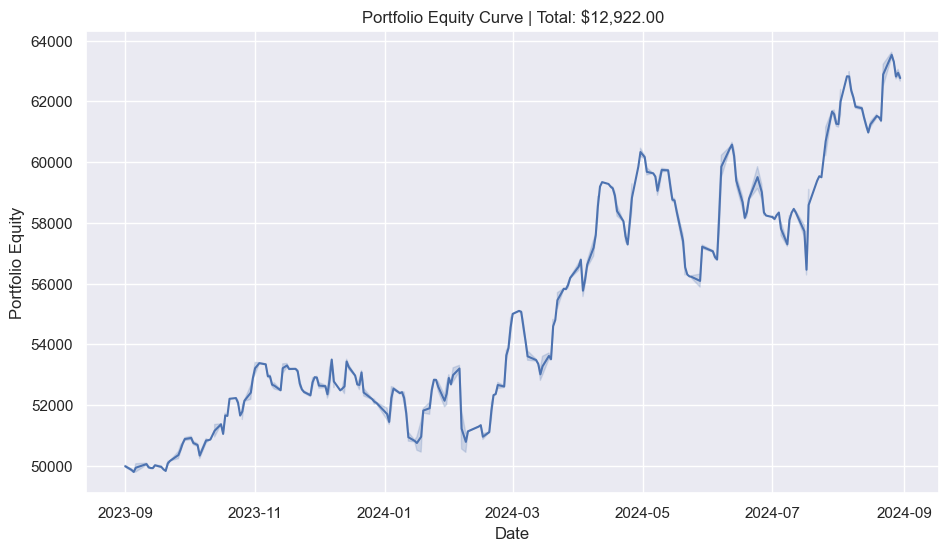

,Metric,Portfolio
0,Deposit,$ 50000.00
1,Profit,$ 12922.00
2,CAGR,25.94%


In [92]:
# Portfolio Profit
portfolio_profit = df['Profit'].sum()

# Final Value
final_portfolio_value = initial_deposit + df['Portfolio PnL'].iloc[-1]

# CAGR
final_portfolio_value = initial_deposit + df['Portfolio PnL'].iloc[-1]
num_years = (df['Time'].max() - df['Time'].min()).days / 365.25
cagr = (final_portfolio_value / initial_deposit) ** (1 / num_years) - 1
cagr *= 100

# Create DataFrame for metrics
df_metrics = pd.DataFrame({
    'Metric': ['Deposit', 'Profit', 'CAGR'],
    'Portfolio': [f'$ {initial_deposit:.2f}', f"$ {df['Portfolio PnL'].iloc[-1]:.2f}", f"{cagr:.2f}%"]
})

plt.figure(figsize=(11, 6))
sns.lineplot(data=df, x='Date', y='Portfolio Equity')
plt.title(f'Portfolio Equity Curve | Total: {f"${portfolio_profit:,.2f}"}')
plt.show()

df_metrics


- CAGR: Compound Annual Growth Rate over the analyzed period.<br>

### Calculating Drawdowns

In [93]:
# Calculate peak drawdown
df['Max_Peak'] = df['Portfolio Equity'].cummax()

# Calculate drawdown
df['Drawdown'] = df['Portfolio Equity'] - df['Max_Peak']
df['Drawdown Percent'] = df['Drawdown'] * 100 / df['Max_Peak']
max_drawdown_financial_portfolio = df['Drawdown'].min()
date_max_drawdown_portfolio = df[df['Drawdown'] == max_drawdown_financial_portfolio]['Date'].values[0]
max_peak_at_drawdown_portfolio = df[df['Date'] == date_max_drawdown_portfolio]['Max_Peak'].values[0]
max_drawdown_percent_portfolio = (max_drawdown_financial_portfolio / max_peak_at_drawdown_portfolio) * 100

# Add to metrics DataFrame
df_metrics_drawdown = pd.DataFrame({
    'Metric': ['Max Drawdown ($)', 
               'Max Drawdown (%)'],
    'Portfolio': [f"$ {max_drawdown_financial_portfolio:.2f}", 
                  f"{max_drawdown_percent_portfolio:.2f}%"]
})

df_metrics = pd.concat([df_metrics, df_metrics_drawdown], ignore_index=True)

# Calculate returns
df['Returns'] = np.log(df['Portfolio Equity'] / df['Portfolio Equity'].shift(1)).fillna(0)

df_metrics


,Metric,Portfolio
0,Deposit,$ 50000.00
1,Profit,$ 12922.00
2,CAGR,25.94%
3,Max Drawdown ($),$ -5038.00
4,Max Drawdown (%),-8.32%


- Max Drawdown: Maximum reduction in capital relative to its previous peak.<br>


#### Drawdown Distribution and Density


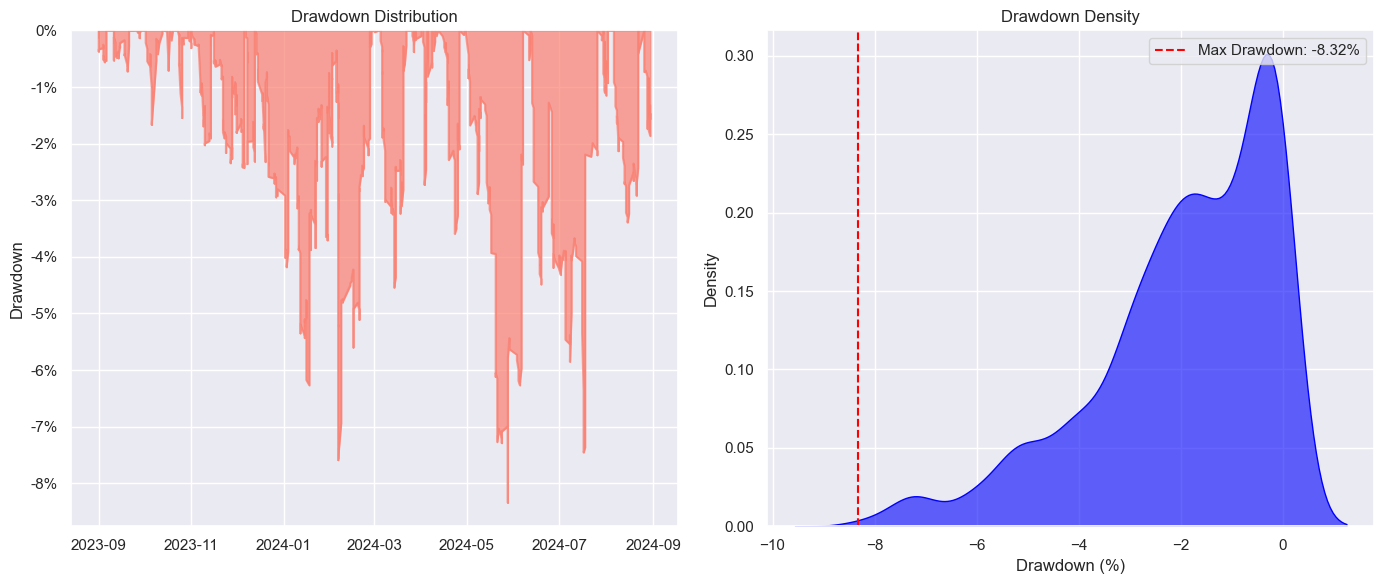

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot drawdown distribution
df['DataIndex'] = df['Date']
df.set_index('DataIndex', inplace=True)
pf.plot_drawdown_underwater(df['Returns'], ax=axes[0])
axes[0].set_title('Drawdown Distribution')

# Plot density chart on the second subplot
sns.kdeplot(df['Drawdown Percent'], fill=True, color='blue', alpha=0.6, ax=axes[1])
max_drawdown_point = df['Drawdown Percent'].min()
axes[1].axvline(max_drawdown_point, color='red', linestyle='--', label=f'Max Drawdown: {max_drawdown_point:.2f}%')
axes[1].legend(loc='best')
axes[1].set_xlabel('Drawdown (%)')
axes[1].set_ylabel('Density')
axes[1].set_title('Drawdown Density')

plt.tight_layout()
plt.show()


In [95]:
# Display values
print(f"Max drawdown relative to deposit = {max_drawdown_financial_portfolio / initial_deposit * 100:.2f}%")

Max drawdown relative to deposit = -10.08%


The maximum drawdown was \$5,038, which represents a drawdown of 8.32% at the time it occurred, and a maximum drawdown of 10.07% relative to the deposit value.<br>


### Calculating Portfolio Volatility


In [96]:
# Calculate daily returns
daily_returns_portfolio = (initial_deposit + df['Portfolio PnL']).pct_change().dropna()

# Calculate volatility
daily_volatility_portfolio = daily_returns_portfolio.std() * 100
trading_days_per_year = 252
annualized_volatility_portfolio = daily_volatility_portfolio * np.sqrt(trading_days_per_year)

# Add to metrics DataFrame
df_metrics_volatility = pd.DataFrame({
    'Metric': ['Daily Volatility', 'Annualized Volatility'],
    'Portfolio': [f"{daily_volatility_portfolio:.2f}%", f"{annualized_volatility_portfolio:.2f}%"]
})

df_metrics = pd.concat([df_metrics, df_metrics_volatility], ignore_index=True)

df_metrics


,Metric,Portfolio
0,Deposit,$ 50000.00
1,Profit,$ 12922.00
2,CAGR,25.94%
3,Max Drawdown ($),$ -5038.00
4,Max Drawdown (%),-8.32%
5,Daily Volatility,0.29%
6,Annualized Volatility,4.65%


- Daily Volatility: Measure of the variability of the portfolio's daily returns.<br>
- Annualized Volatility: Daily volatility adjusted to an annual basis, reflecting the portfolio's risk over the year.<br>



For the benchmark analysis, we will use the main brazilian stock index, the Ibovespa, as this portfolio operated in the brazilian market.

### Collecting Benchmark Data - Ibovespa<br>


In [97]:
# Collect API data
symbol = '^BVSP'
df_benchmark = yf.download(symbol, start=start_date, end=end_date)
close_prices_benchmark = df_benchmark['Close']

[*********************100%***********************]  1 of 1 completed


##### Calculating Benchmark Returns, Maximum Drawdown, and Volatility, and Adding to DataFrame


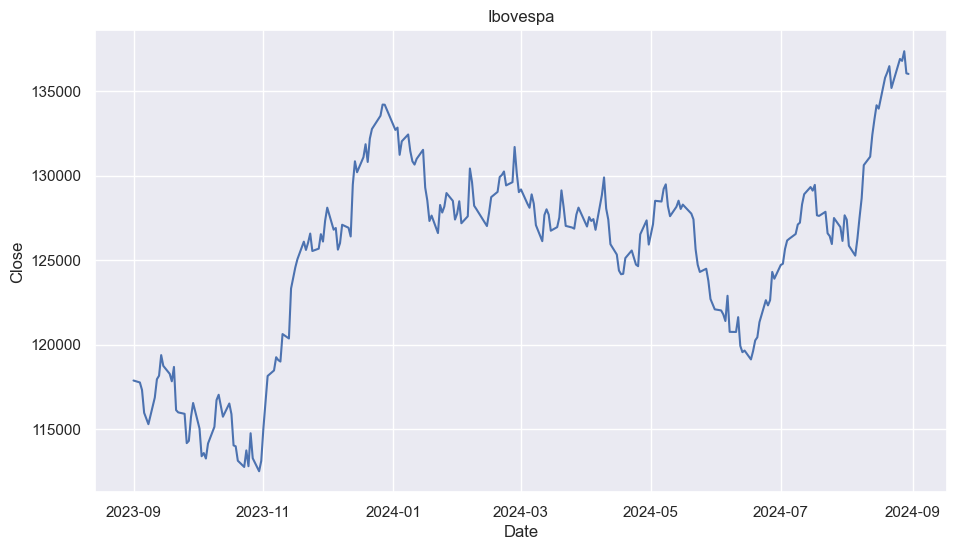

In [98]:
# Normalize the closing price to reflect the initial deposit
close_prices_normalized_benchmark = (close_prices_benchmark / close_prices_benchmark.iloc[0]) * initial_deposit

# Calculate total absolute return
initial_price_benchmark = close_prices_normalized_benchmark.iloc[0]
final_price_benchmark = close_prices_normalized_benchmark.iloc[-1]
total_absolute_return_benchmark = (final_price_benchmark - initial_price_benchmark) / initial_price_benchmark

# Calculate daily returns
daily_returns_benchmark = close_prices_normalized_benchmark.pct_change().dropna()

# Calculate maximum drawdown
cumulative_benchmark = close_prices_normalized_benchmark.cummax()
drawdown_benchmark = (close_prices_normalized_benchmark - cumulative_benchmark) / cumulative_benchmark

# Find the date of the maximum drawdown
max_drawdown_date_benchmark = drawdown_benchmark.idxmin()

# Get the value of the maximum cumulative drawdown on the date of the maximum drawdown
max_peak_at_drawdown_benchmark = cumulative_benchmark.loc[max_drawdown_date_benchmark]

# Get financial value of the maximum drawdown
max_drawdown_value_benchmark = drawdown_benchmark.loc[max_drawdown_date_benchmark] * initial_deposit

# Calculate maximum drawdown percentage
max_drawdown_percent_benchmark = (max_drawdown_value_benchmark / max_peak_at_drawdown_benchmark) * 100

# Calculate daily volatility
daily_volatility_benchmark = daily_returns_benchmark.std() * 100

# Calculate annualized volatility
trading_days_per_year = 252
annualized_volatility_benchmark = daily_volatility_benchmark * np.sqrt(trading_days_per_year)

# Calculate theoretical buy and hold profit on the benchmark
benchmark_profit = total_absolute_return_benchmark * initial_deposit
final_value_benchmark = initial_deposit + benchmark_profit
num_years = (df['Time'].max() - df['Time'].min()).days / 365.25
cagr_benchmark = (final_value_benchmark / initial_deposit) ** (1 / num_years) - 1
cagr_benchmark *= 100

# Add new column to metrics DataFrame for benchmark
df_metrics['Benchmark'] = [
    f'$ {initial_deposit:.2f}', 
    f'$ {benchmark_profit:.2f}', 
    f'{cagr_benchmark:.2f}%', 
    f"$ {max_drawdown_value_benchmark:.2f}",
    f"{max_drawdown_percent_benchmark:.2f}%",
    f"{daily_volatility_benchmark:.2f}%", 
    f"{annualized_volatility_benchmark:.2f}%", 
]

plt.figure(figsize=(11, 6))
sns.lineplot(data=close_prices_benchmark)
plt.title('Ibovespa')
plt.show()


In [99]:
df_metrics

,Metric,Portfolio,Benchmark
0,Deposit,$ 50000.00,$ 50000.00
1,Profit,$ 12922.00,$ 7681.12
2,CAGR,25.94%,15.42%
3,Max Drawdown ($),$ -5038.00,$ -5609.79
4,Max Drawdown (%),-8.32%,-9.86%
5,Daily Volatility,0.29%,0.81%
6,Annualized Volatility,4.65%,12.89%


In [100]:
# Print maximum financial drawdown relative to the deposit
print(max_drawdown_value_benchmark / initial_deposit * 100)


-11.219577626421458


A financial allocation of the total initial deposit value was considered for comparison purposes*.<br>

The maximum financial drawdown was $5,609.79, which represents a 9.86% drawdown at the time it occurred, and a maximum drawdown of 11.21% relative to the deposit amount.

During the analyzed period, the benchmark appreciated by 15.42%, a significant value considering it is an emerging market index and the one-year observation window.<br>

*Ibovespa is a theoretical portfolio; however, the operation could easily be performed through an ETF tracking the index, for example.

### Calculating Portfolio's Linear Regression


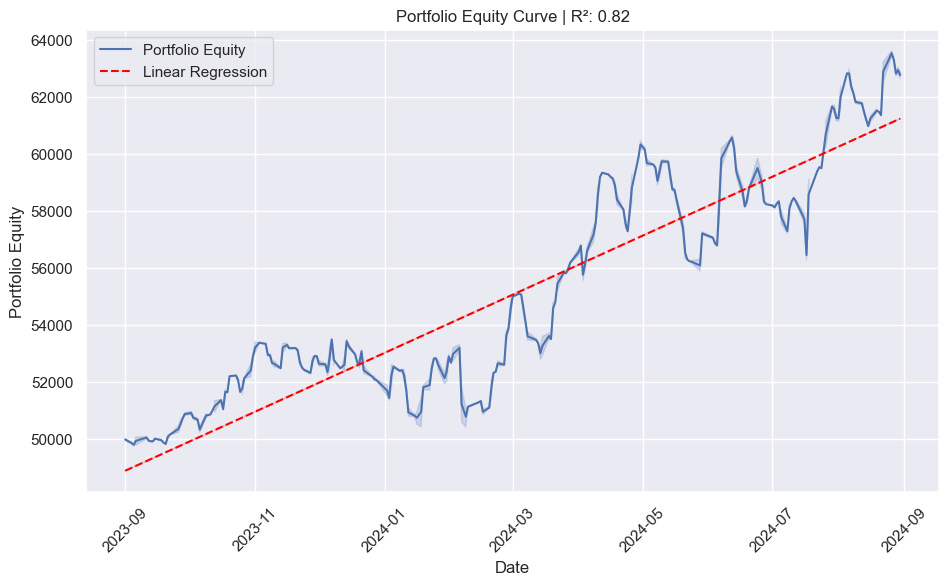

In [101]:
# Convert the date column to ordinal numbers for regression
df['Time_ordinal'] = df['Time'].map(pd.Timestamp.toordinal)

# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(df['Time_ordinal'], df['Portfolio Equity'])

# Calculate R²
r_squared = r_value**2

# Add the regression line to the DataFrame
df['Regression'] = intercept + slope * df['Time_ordinal']

# Add R² to our metrics DataFrame
df_metrics_portfolio_lr = pd.DataFrame({'Metric': ['Curve Smoothness - R²'], 'Portfolio': [f'{r_squared:.2f}']})
df_metrics = pd.concat([df_metrics, df_metrics_portfolio_lr], ignore_index=True)

# Plot the portfolio equity and regression line
plt.figure(figsize=(11, 6))
sns.lineplot(data=df, x='Date', y='Portfolio Equity', label='Portfolio Equity')
sns.lineplot(data=df, x='Date', y='Regression', color='red', linestyle='--', label='Linear Regression')

plt.title(f'Portfolio Equity Curve | R²: {r_squared:.2f}')
plt.xlabel('Date')
plt.ylabel('Portfolio Equity')
plt.xticks(rotation=45)
plt.legend()
plt.show()


#### Calculating Benchmark's Linear Regression

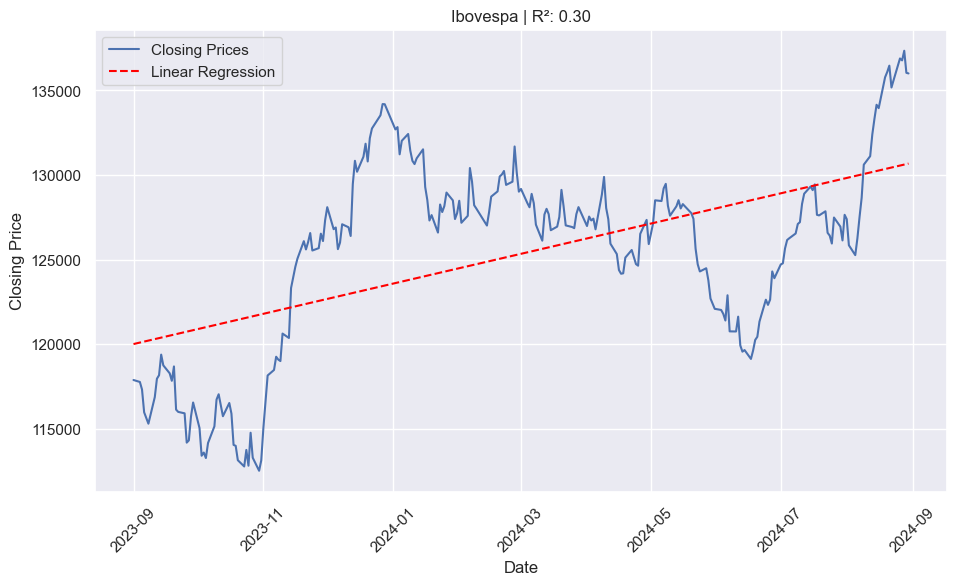

,Metric,Portfolio,Benchmark
0,Deposit,$ 50000.00,$ 50000.00
1,Profit,$ 12922.00,$ 7681.12
2,CAGR,25.94%,15.42%
3,Max Drawdown ($),$ -5038.00,$ -5609.79
4,Max Drawdown (%),-8.32%,-9.86%
5,Daily Volatility,0.29%,0.81%
6,Annualized Volatility,4.65%,12.89%
7,Curve Smoothness - R²,0.82,0.30


In [102]:
# Reset the index to use the date column
df_benchmark.reset_index(inplace=True)

# Convert the date column to ordinal numbers for regression
df_benchmark['Time_ordinal'] = df_benchmark['Date'].map(pd.Timestamp.toordinal)

# Calculate linear regression
slope_benchmark, intercept_benchmark, r_value_benchmark, p_value_benchmark, std_err_benchmark = linregress(df_benchmark['Time_ordinal'], df_benchmark['Close'])

# Calculate R²
r_squared_benchmark = r_value_benchmark**2

# Add the regression line to the DataFrame
df_benchmark['Regression'] = intercept_benchmark + slope_benchmark * df_benchmark['Time_ordinal']

# Add the R² metric to the metrics DataFrame
df_metrics.loc[df_metrics['Metric'] == 'Curve Smoothness - R²', 'Benchmark'] = f'{r_squared_benchmark:.2f}'

# Plot the benchmark prices and regression line
plt.figure(figsize=(11, 6))
sns.lineplot(data=df_benchmark, x='Date', y='Close', label='Closing Prices')
sns.lineplot(data=df_benchmark, x='Date', y='Regression', color='red', linestyle='--', label='Linear Regression')

plt.title(f'Ibovespa | R²: {r_squared_benchmark:.2f}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Display the updated metrics DataFrame
df_metrics


 - R²: Represents the variability of the return distribution through the linear regression model and can be interpreted as the stability of the curve.

### Calculating Portfolio Performance Metrics

In [103]:
# Recovery Factor
recovery_factor_portfolio = abs(portfolio_profit / max_drawdown_financial_portfolio)

# Filter winning and losing trades
num_winning_trades = df[df['Profit'] > 0].shape[0]
winning_trades = df[df['Profit'] > 0]['Profit']
losing_trades = df[df['Profit'] < 0]['Profit']
num_total_trades = df.shape[0]

# Calculate the win rate
win_rate = (num_winning_trades / num_total_trades) * 100 if num_total_trades > 0 else 0

# Calculate the average of winning and losing trades
average_winning = winning_trades.mean()
average_losing = losing_trades.mean()

payoff = average_winning / -average_losing

# Calculate breakeven
breakeven = (1 / (1 + payoff)) * 100

# Calculate edge
edge = win_rate - breakeven

# Profit Factor
total_wins = df[df['Profit'] > 0]['Profit'].sum()
total_losses = df[df['Profit'] < 0]['Profit'].sum()
profit_factor = total_wins / abs(total_losses) if total_losses != 0 else np.nan

# Expected Value
average_payoff = average_winning / -average_losing
expected_value = (win_rate / 100 * average_payoff) - ((100 - win_rate) / 100)
expected_value *= 100

# Add to metrics dataframe
df_metrics_performance = pd.DataFrame({
    'Metric': ['Recovery Factor',
               'Win Rate', 
               'Payoff', 
               'Edge', 
               'Profit Factor',                 
               'Expected Value',],
    'Portfolio': [f'{recovery_factor_portfolio:.2f}',
                  f"{win_rate:.2f}%", 
                  f"{payoff:,.2f}", 
                  f"{edge:,.2f}%", 
                  f"{profit_factor:.2f}", 
                  f"{expected_value:.2f}%"
                 ]
})

df_metrics = pd.concat([df_metrics, df_metrics_performance], ignore_index=True)

df_metrics


,Metric,Portfolio,Benchmark
0,Deposit,$ 50000.00,$ 50000.00
1,Profit,$ 12922.00,$ 7681.12
2,CAGR,25.94%,15.42%
3,Max Drawdown ($),$ -5038.00,$ -5609.79
4,Max Drawdown (%),-8.32%,-9.86%
5,Daily Volatility,0.29%,0.81%
6,Annualized Volatility,4.65%,12.89%
7,Curve Smoothness - R²,0.82,0.30
8,Recovery Factor,2.56,NaN
9,Win Rate,47.67%,NaN


Understanding the metrics:
- Recovery Factor: Ratio between annual return and maximum drawdown, indicating the ability to recover after losses.<br>
- Win Rate: Percentage of successful trades (profits) relative to the total number of trades.<br>
- Payoff: Ratio between average profit and average loss per trade.<br>
- Edge: Indicates the potential profitability of the strategy/portfolio and its difference from random win rate.<br>
- Profit Factor: Ratio between total profit and total loss.<br>
- Expected Value: Average expected profit or loss per trade considering the average risk as a reference.<br>



To calculate risk-adjusted return indicators, we need to obtain the risk-free rate, which in Brazil is represented by the Selic rate.

### Calculating the Risk-Free Rate for the Period

Average Selic rate for the period: 11.41%


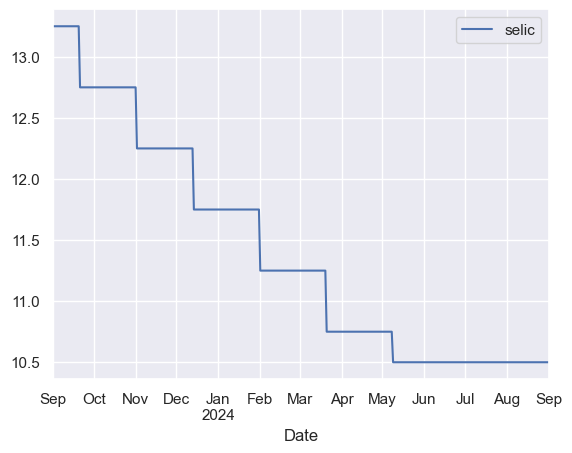

In [104]:
# Retrieve data from the Central Bank API
selic = sgs.get({'selic': 432}, start=start_date, end=end_date)

average_risk_free_rate = selic['selic'].mean()
risk_free_rate = average_risk_free_rate / 100

sns.set_theme()
selic.plot()
print(f"Average Selic rate for the period: {average_risk_free_rate:.2f}%")



It's interesting to note that there is a clear scenario of monetary policy easing during the period.

### Calculating Sharpe Ratio and VaR

In [105]:
# Sharpe Ratio
portfolio_return = (portfolio_profit) / initial_deposit
std_dev = df['Profit'].std() / initial_deposit
sharpe_ratio_portfolio = (portfolio_return - risk_free_rate) / (annualized_volatility_portfolio / 100) if std_dev != 0 else np.nan

# VaR
# Creating and processing daily portfolio profits 
df['daily_profit_portfolio'] = df.groupby('Date')['Profit'].transform('sum')
df_daily_profit_portfolio = df[['Date', 'daily_profit_portfolio']].copy()
df_daily_profit_portfolio = df_daily_profit_portfolio.drop_duplicates(subset='Date', keep='first')
df_daily_profit_portfolio['Portfolio Value'] = initial_deposit + df_daily_profit_portfolio['daily_profit_portfolio'].cumsum()
df_daily_profit_portfolio['Daily Return'] = df_daily_profit_portfolio['Portfolio Value'].pct_change()
df_daily_profit_portfolio = df_daily_profit_portfolio.dropna(subset=['Daily Return'])

# Calculate VaR
conf_level = 0.95
var_portfolio = df_daily_profit_portfolio['Daily Return'].quantile(1 - conf_level)
var_portfolio *= 100

# Add to metrics DataFrame
df_metrics_risk = pd.DataFrame({
    'Metric': ['Sharpe Ratio', 
               #'Calmar Ratio', 
               'VaR (95%)'],
    'Portfolio': [f"{sharpe_ratio_portfolio:.2f}", 
              #f"{calmar_ratio:,.2f}",  
              f"{var_portfolio:.2f}%"]
})

df_metrics = pd.concat([df_metrics, df_metrics_risk], ignore_index=True)


### Calculating Performance Metrics Applicable to the Benchmark

Not all performance metrics are applicable to the benchmark. For example, the payoff represents the average between winning and losing trades, which does not make sense to calculate for the benchmark as it is considered only as a theoretical buy-and-hold strategy.


In [106]:
# Calculate Recovery Factor for the benchmark
fr_benchmark = benchmark_profit / -max_drawdown_value_benchmark

# Sharpe Ratio
retorno_benchmark = (benchmark_profit) / initial_deposit
sharpe_ratio_benchmark = (retorno_benchmark - risk_free_rate) / (annualized_volatility_benchmark / 100)

# VaR
df_benchmark['Daily Return'] = df_benchmark['Close'].pct_change()
df_benchmark = df_benchmark.dropna(subset=['Daily Return'])

conf_level = 0.95
var_benchmark = df_benchmark['Daily Return'].quantile(1 - conf_level)
var_benchmark *= 100

# Add metrics to the DataFrame
df_metrics.loc[df_metrics['Metric'] == 'Recovery Factor', 'Benchmark'] = f'{fr_benchmark:.2f}'
df_metrics.loc[df_metrics['Metric'] == 'Sharpe Ratio', 'Benchmark'] = f'{sharpe_ratio_benchmark:.2f}'
df_metrics.loc[df_metrics['Metric'] == 'VaR (95%)', 'Benchmark'] = f'{var_benchmark:.2f}%'
df_metrics;


- Sharpe Ratio: A measure of risk-adjusted return, calculated as the excess return over the risk-free rate divided by the volatility.<br>
- VaR (95%): Value at Risk, indicating the maximum expected loss with 95% confidence over a specific period, which in this case refers to daily values.<br>

### Results Overview

Let's plot the two graphs side by side for comparison.

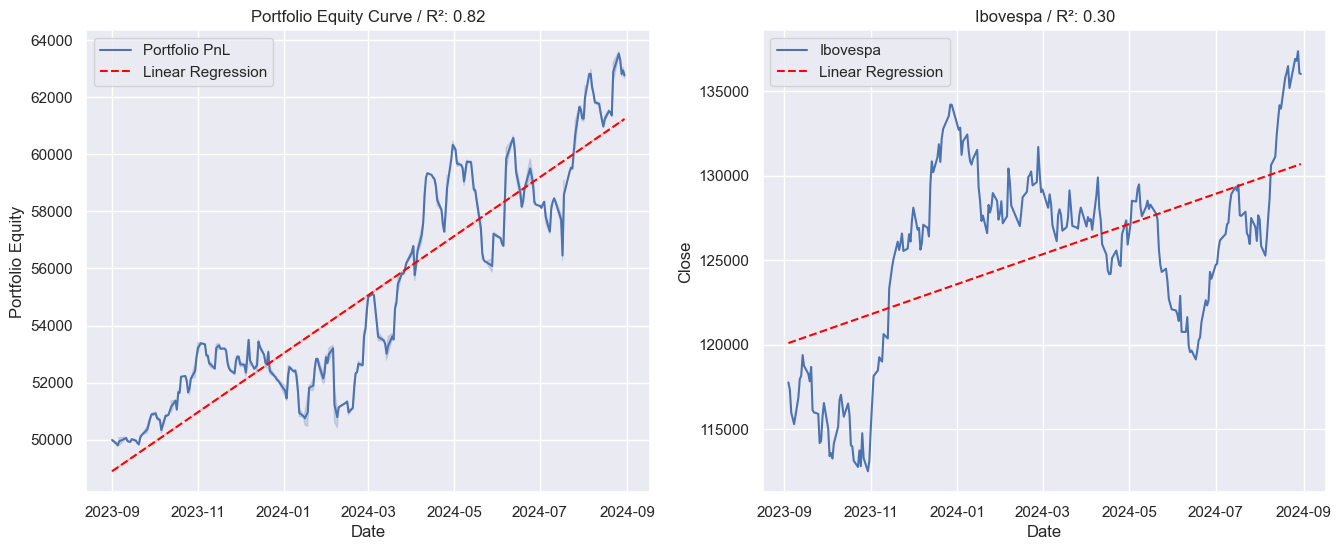

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(data=df, x='Date', y='Portfolio Equity', label='Portfolio PnL',ax=axes[0])
sns.lineplot(data=df, x='Date', y='Regression', color='red', linestyle='--', label='Linear Regression', ax=axes[0])
axes[0].set_title(f'Portfolio Equity Curve / R²: {r_squared:.2f}')

sns.lineplot(data=df_benchmark, x='Date', y='Close', label='Ibovespa',ax=axes[1])
sns.lineplot(data=df_benchmark, x='Date', y='Regression', color='red', linestyle='--', label='Linear Regression', ax=axes[1])
axes[1].set_title(f'Ibovespa / R²: {r_squared_benchmark:.2f}');

In [108]:
df_metrics.fillna("N/A")

,Metric,Portfolio,Benchmark
0,Deposit,$ 50000.00,$ 50000.00
1,Profit,$ 12922.00,$ 7681.12
2,CAGR,25.94%,15.42%
3,Max Drawdown ($),$ -5038.00,$ -5609.79
4,Max Drawdown (%),-8.32%,-9.86%
5,Daily Volatility,0.29%,0.81%
6,Annualized Volatility,4.65%,12.89%
7,Curve Smoothness - R²,0.82,0.30
8,Recovery Factor,2.56,1.37
9,Win Rate,47.67%,N/A


Let's analyze the metrics. Values with N/A for the benchmark are metrics that are not applicable to systems with only one operation (buy and hold).

#### Portfolio vs. Benchmark

The portfolio demonstrated superior performance compared to the Ibovespa in nearly all evaluated metrics. With a return of 25.94% compared to 15.42% for the Ibovespa, and a drawdown of -8.32% versus -9.86% for the index, the portfolio delivered much higher returns while maintaining a relatively similar drawdown. The annualized volatility was significantly lower, 4.65% versus 12.89% for the Ibovespa, highlighting the greater stability and consistency of the portfolio over the period.

Additionally, the portfolio achieved a remarkably high Sharpe Ratio of 3.10, far surpassing the 0.31 of the Ibovespa, indicating an excellent risk-return investment. The coefficient of determination (R²) of 0.82, compared to 0.30 for the benchmark, highlights the superior stability of returns and the consistency of the portfolio's performance curve, reflecting its effectiveness in capturing alpha in the market with lower return volatility. Greater stability can also be observed visually in the charts.

However, the VaR showed a slight disadvantage, with the portfolio recording -1.41% compared to -1.21% for the Ibovespa. This result suggests a higher exposure to negative events. Let's analyze the trade distribution chart of the portfolio.

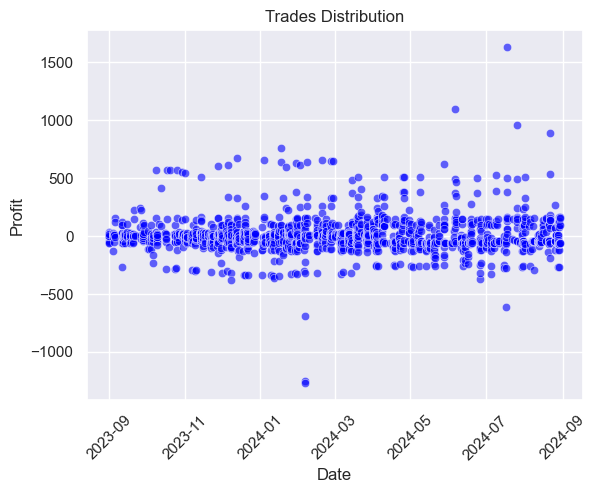

In [109]:
sns.scatterplot(data=df, x='Date', y='Profit', color='blue', alpha=0.6)
plt.title('Trades Distribution')
plt.ylabel('Profit')
plt.xticks(rotation=45);

There is a uniform distribution throughout most of the analyzed period. Although winning outliers seem to be larger than losing ones, the losing outliers negatively impacted the VaR, as it is an indicator that evaluates risk more rigorously. Despite the small difference between the VaR of the portfolio and the benchmark, it would be interesting to delve deeper into the analysis and improve the algorithms to try to mitigate the impact of extreme events and enhance control over the potential maximum risk of the portfolio.

#### Investment Allocation Hypothesis

For performance comparison purposes, the benchmark used was the buy-and-hold of the entire deposited amount. However, this approach does not consider the possibility of allocating capital across different investments.

In the case of this portfolio, which operates exclusively in intraday trading, the required operational margin is significantly lower. Therefore, it is feasible to use a reduced margin allocation compared to the total amount invested.

For example, by allocating only 30% of the capital as margin (equivalent to $15,000, or 3 times the maximum observed drawdown), it is possible to invest the remaining 70% in risk-free fixed income. This strategy not only keeps the intraday operation efficient with an optimized margin allocation but also provides additional returns from investing in lower-risk products, making the overall return on investment even more attractive.

Let's calculate the return on fixed income for the period and evaluate this scenario.

##### Calculating Fixed Income Return
Considering the hypothesis of allocating 70% of the capital in fixed income, we will calculate its average return over the period.

In [110]:
fixedincome_alocated_capital = initial_deposit * 0.70
fixedincome_yield = fixedincome_alocated_capital * average_risk_free_rate / 100
profit_total = portfolio_profit + fixedincome_yield

final_capital_total = initial_deposit + profit_total
num_years = (df['Time'].max() - df['Time'].min()).days / 365.25
cagr_total = (final_capital_total / initial_deposit) ** (1 / num_years) - 1
cagr_total *= 100

df['FixedIncomeYield'] = fixedincome_yield * (df['Time'] - df['Time'].min()).dt.days / 365.25
df['Total Equity'] = df['Portfolio Equity'] + df['FixedIncomeYield']
print(f"Fixed income profit over the period: ${fixedincome_yield:.2f}")


Fixed income profit over the period: $3992.81


Plotting the Final Capital Curve

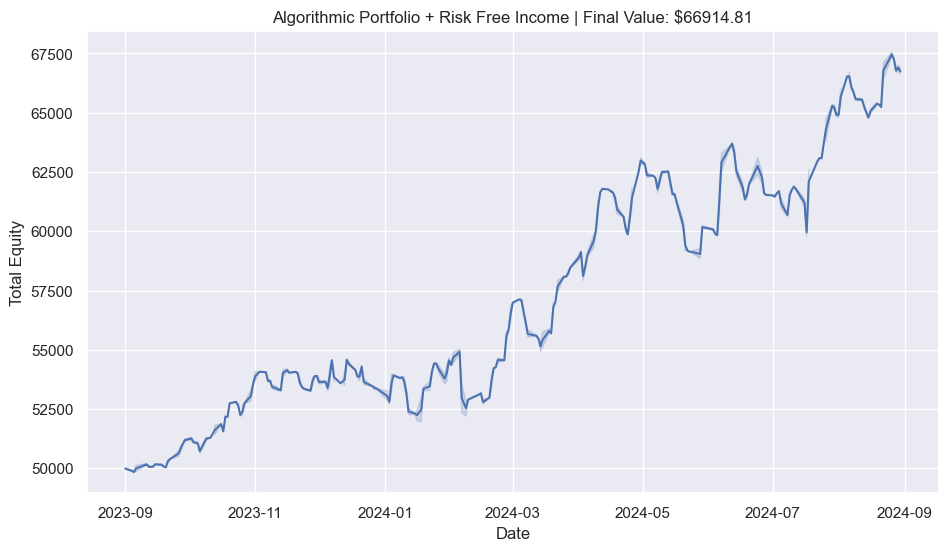

Algorithmic Portfolio Profit: $12922.00
Fixed Income Profit: $3992.81
Total Profit (Algorithmic Portfolio + Risk Free Income): $16914.81
Final Total Value (Algorithmic Portfolio + Fixed Income): $66914.81
CAGR Total (Algorithmic Portfolio + Fixed Income): 33.96%


In [111]:
plt.figure(figsize=(11, 6))
sns.lineplot(data=df, x='Date', y='Total Equity')
plt.title(f'Algorithmic Portfolio + Risk Free Income | Final Value: ${final_capital_total:.2f}')
plt.xlabel('Date')
plt.ylabel('Total Equity')
plt.show()

# Display calculated values
print(f"Algorithmic Portfolio Profit: ${portfolio_profit:.2f}")
print(f"Fixed Income Profit: ${fixedincome_yield:.2f}")
print(f"Total Profit (Algorithmic Portfolio + Risk Free Income): ${profit_total:.2f}")
print(f"Final Total Value (Algorithmic Portfolio + Fixed Income): ${final_capital_total:.2f}")
print(f"CAGR Total (Algorithmic Portfolio + Fixed Income): {cagr_total:.2f}%")


By using an allocation of 30% of the capital for the portfolio and 70% for fixed income, the investor would achieve an additional amount of $3992.81 on the risk-free investment.

When combining the returns from the algorithmic portfolio, the investor's final capital would be $66,914.81, reflecting a total annualized return of 33.96% while keeping the maximum drawdown at 8.32%. This allocation further enhances the investment's attractiveness.

### Final Thoughts

This exploratory analysis revealed that, even in a scenario of monetary policy easing and with the Ibovespa appreciating about 16% during the period, incorporating the algorithmic portfolio into the investor's portfolio resulted in a substantially higher return compared to the benchmark. Both capital allocation strategies analyzed — investing the entire amount in the portfolio or allocating part to fixed income — showed superior and significant results.

Utilizing the portfolio allowed for a more efficient distribution of returns, resulting in robust performance metrics and very satisfactory risk-adjusted return indicators. Considering an average risk-free rate of 11.41% during the period, the Sharpe Ratio of 3.1 stands out remarkably.

This study offers valuable insights for investors on integrating algorithms and automation into their investment strategies, highlighting the importance of well-planned and diversified capital allocation to maximize returns and manage risks effectively.